# UMAP and Clustering on Sim Stats

This notebook compares patterns in the *initial* export of similarity statistics.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import dask.dataframe as dd
import seaborn as sns
import altair as alt
import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster as cluster

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/conda/lib/python3.6/site-packages/pandas/core/index.py:29: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  FutureWarning,


In [37]:
stats = dd.read_parquet('/data/saddl/tmp-comp-output/4*')
# Add columns that show SW Runs as proportions of size
for t in [.1, .4, .5, 1]:
    for s in ['L', 'R']:
        stats[s+'SW{:04.0f}Prop'.format(t*10)] = stats['SW{:04.0f}Len'.format(t*10)] / stats[s+'Size']
featcols = []
for v in ['glove']:
    featcols.append(v+'MeanSim')
    for s in ['L']: #, 'R']:
        featcols += [v+s+'MeanMinSim', v+s+'TruncSim']
        featcols += ['{}{}PropDist{:04.0f}'.format(v,s,t*10) for t in [0.5, 1, 3]] #,0.2]]
        featcols += [s+'SW{:04.0f}Prop'.format(t*10) for t in [.4, .5]] #, .1, 1]]
print(featcols)

['gloveMeanSim', 'gloveLMeanMinSim', 'gloveLTruncSim', 'gloveLPropDist0005', 'gloveLPropDist0010', 'gloveLPropDist0030', 'LSW0004Prop', 'LSW0005Prop']


In [39]:
sample = stats.sample(frac=0.2).compute()
sample.shape

(140105, 32)

In [41]:
%%time
# Reduce dimensionality with UMAP, to help clustering a bit. https://umap-learn.readthedocs.io/en/latest/clustering.html
clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=4, random_state=42).fit_transform(sample[featcols])

CPU times: user 40min 10s, sys: 21min 12s, total: 1h 1min 22s
Wall time: 5min 39s


In [42]:
# Cluster the dimensionally-reduced data. At least when visualized, this made a big difference.
#Labels are available in clusterer.labels_ and probabilities in probabilities_
clusterer = hdbscan.HDBSCAN(min_cluster_size=300, gen_min_span_tree=True)
clusterer.fit(clusterable_embedding)
pd.Series(clusterer.labels_).value_counts().head(100)

 9     50732
 13    44766
 2     15618
 4     15355
 1      4507
-1      2871
 8      1576
 6       809
 3       743
 5       684
 11      638
 0       626
 10      506
 7       369
 12      305
dtype: int64

In [60]:
%%time
# Reduce to 2-dimensions for visualization
reducer = umap.UMAP()
embedding = reducer.fit_transform(sample[featcols][:30000])
embedding.shape

/opt/conda/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/opt/conda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 1min 29s, sys: 52.6 s, total: 2min 21s
Wall time: 32.5 s


(30000, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


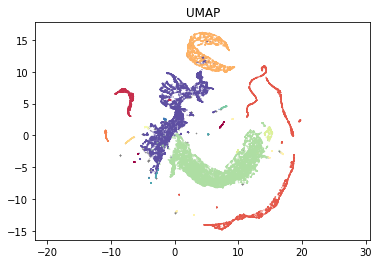

In [84]:
# Visualize
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP', fontsize=12);
clustered = (clusterer.labels_ >= 0)[:30000]
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=clusterer.labels_[:30000][clustered],
            s=0.1,
            cmap='Spectral');

## Investigating the top clusters

In [49]:
sample['cluster'] = clusterer.labels_
top_clusters = sample['cluster'].value_counts().head(10).index.values
top_clusters = top_clusters[top_clusters != -1]
top_clusters

array([ 9, 13,  2,  4,  1,  8,  6,  3,  5])

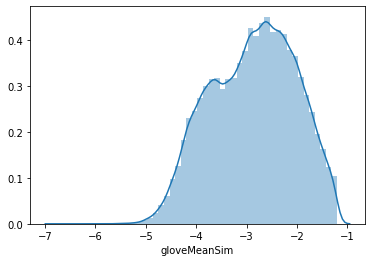

In [83]:
import numpy as np
a = sample.gloveMeanSim
a = a[a <0.3]
a = a.apply(np.log)
sns.distplot(a)

In [50]:
from scipy.stats import zscore
zscores = sample[featcols].apply(zscore) # z scores for all rows
zscores['cluster'] = clusterer.labels_
cluster_zscores = zscores.groupby('cluster').mean().sort_values('LSW0005Prop', ascending=False)
cluster_zscores.head(2)

,gloveMeanSim,gloveLMeanMinSim,gloveLTruncSim,gloveLPropDist0005,gloveLPropDist0010,gloveLPropDist0030,LSW0004Prop,LSW0005Prop
cluster,,,,,,,,
8,-0.504541,-0.403770,-0.363636,1.388212,1.025901,0.606045,1.487550,1.514197
6,0.448794,-0.412821,-0.372761,1.388761,1.025915,0.606031,1.655818,1.512026


In [58]:
from compare_tools.configuration import config
from compare_tools.hathimeta import HathiMeta, meta_compare
meta = HathiMeta(config['metadb_path'])
pd.set_option('display.max_colwidth', 2000)

markdown = ""
for label in cluster_zscores.index:
    label_sample = sample[clusterer.labels_ == label]
    if label == -1:
        markdown += "## Label {} (The 'unclusterables' - {} relationships)\n\n".format(label, len(label_sample))
    else:
        markdown += "## Label {} ({} relationships)\n\n".format(label, len(label_sample))
    markdown += "### Mean Z-Scores\n\n" + cluster_zscores.loc[[label]].to_markdown() + "\n\n### Examples\n\n"
    for i, row in label_sample[['left', 'right']].sample(6).iterrows():
        a = meta_compare(row.left, row.right, meta)
        markdown += a.to_markdown() + "\n\n[Left](http://hdl.handle.net/2027/{})|[Right](http://hdl.handle.net/2027/{})\n------\n\n".format(row.left, row.right)
    #

In [59]:
print(markdown)

## Label 8 (1576 relationships)

### Mean Z-Scores

|   cluster |   gloveMeanSim |   gloveLMeanMinSim |   gloveLTruncSim |   gloveLPropDist0005 |   gloveLPropDist0010 |   gloveLPropDist0030 |   LSW0004Prop |   LSW0005Prop |
|----------:|---------------:|-------------------:|-----------------:|---------------------:|---------------------:|---------------------:|--------------:|--------------:|
|         8 |      -0.504541 |           -0.40377 |        -0.363636 |              1.38821 |               1.0259 |             0.606045 |       1.48755 |        1.5142 |

### Examples

|       | title                                    | author                      |   oclc_num |   page_count | description   |
|:------|:-----------------------------------------|:----------------------------|-----------:|-------------:|:--------------|
| left  | The three panics; an historical episode. | Cobden, Richard, 1804-1865. |   21711551 |          168 |               |
| right | The three panics; an histo

In [52]:
import markdown2
from IPython.core.display import display, HTML
display(HTML(markdown2.markdown(markdown)))